# Amazon Fine Food Reviews Analysis:

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

Data Published by:Originally this data was published by Stanford Network Analysis Project Team.

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3,as we can't be sure about the polarity of the reviews with Score 3.
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews WHERE Score != 3 ", con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data_copy=filtered_data.copy()

 #  Exploratory Data Analysis

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
dup=filtered_data.duplicated(subset=['ProductId','UserId','Time','HelpfulnessNumerator','HelpfulnessDenominator','Score','Text'],keep=False)

In [5]:
filtered_data.loc[dup,:].shape

(718, 10)

In [6]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
#Deduplication of entries
After_dedup=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text",'HelpfulnessNumerator','HelpfulnessDenominator','Score'}, keep='first', inplace=False)
print(After_dedup.shape)

(365910, 10)


In [8]:
dup1=After_dedup.duplicated(subset=["UserId","ProfileName","Time","Text"],keep=False)


In [9]:
After_dedup.loc[dup1,:].shape

(3067, 10)

In [10]:
#Sorting data according to ProductId in ascending order
sorted_After_dedup_data=After_dedup.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Again Deduplication of entries
After_dedup=sorted_After_dedup_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(After_dedup.shape)

(364173, 10)


In [12]:
#Checking to see how much % of data still remains
((After_dedup['Id'].size)*1.0)/((filtered_data['Id'].size)*1.0)*100

69.25890143662969

Observation: Again it's found that for the below 2 Users the HelpfulnessNumerator is greater than HelpfulnessDenominator.But it is practically not possible,so they need to be removed as well.

In [13]:
After_dedup[After_dedup.HelpfulnessNumerator>After_dedup.HelpfulnessDenominator]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
59301,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,positive,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
41159,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,positive,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
After_dedup=After_dedup[After_dedup.HelpfulnessNumerator<=After_dedup.HelpfulnessDenominator]

In [15]:
After_dedup.shape

(364171, 10)

In [16]:
# Now let's see the Positive and Negetive Scores in our dataset:

In [17]:
After_dedup['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [18]:
Prob=After_dedup[After_dedup['Score']=='positive'].size/(After_dedup[After_dedup['Score']=='negative'].size+After_dedup[After_dedup['Score']=='positive'].size)

In [19]:
print("The Probability of Positive Score :",Prob)

The Probability of Positive Score : 0.843178067446337


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [20]:
# find sentences containing HTML tags
import re
i=0;
for sent in After_dedup['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

2
In June<br />I saw a charming group<br />of roses all begin<br />to droop<br />I pepped them up<br />with chicken soup!<br />Sprinkle once<br />sprinkle twice<br />sprinkle chicken soup<br />with rice<br /><br />This is a great book to teach children the months of the year. The repetition of the phrases and the funny little stories with accompanying pictures make for an ideal bedtime read. This isn't nearly as good as some of Sendak's other books (like Where the Wild Things are or Pierre: The Boy Who Didn't Care), but it still carries his unique brand of charm.


In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Faced a Problem Fetching the stopwords,hence from nltk library stopwords needed to be downloaded.

In [23]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(stop)
print('************************************')
print(sno.stem('tasty'))

************************************
tasti


In [24]:
stop.remove('not') #Actually before eliminating Stopwords,'not' as stopword must me removed before applying BoW technique.
                   # After removing 'not' again executing the code the KeyError is 'not',as it is not in set.

In [25]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in After_dedup['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (After_dedup['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(After_dedup['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [26]:
After_dedup['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
After_dedup['CleanedText']=After_dedup['CleanedText'].str.decode("utf-8")

In [27]:
After_dedup.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('After_dedup.sqlite')
c=conn.cursor()
conn.text_factory = str
After_dedup.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

**Time Based Splitting:**

In [28]:
nwdf1=After_dedup.sort_values(by="Time")

Considering First 20000 points for both Predictor and Target variable to be fed 
into Train,CV,Test dataframes in 60:20:20 Ratio.

In [29]:
X_Train=nwdf1['CleanedText'].iloc[:12000]
X_cv=nwdf1['CleanedText'].iloc[12000:16000]
X_Test=nwdf1['CleanedText'].iloc[16000:20000]
Y_Train=nwdf1["Score"].iloc[:12000]
Y_cv=nwdf1['Score'].iloc[12000:16000]
Y_Test=nwdf1["Score"].iloc[16000:20000]

#### Encoding of Target Class:

In [30]:
Y_Train=Y_Train.astype('category')
Y_Train=Y_Train.cat.codes
Y_Test=Y_Test.astype('category')
Y_Test=Y_Test.cat.codes
Y_cv=Y_cv.astype('category')
Y_cv=Y_cv.cat.codes

In [31]:
X_Train_copy=X_Train.copy()
X_cv_copy=X_cv.copy()
X_Test_copy=X_Test.copy()
Y_Train_copy=Y_Train.copy()
Y_cv_copy=Y_cv.copy()
Y_Test_copy=Y_Test.copy()

In [32]:
from sklearn.preprocessing import StandardScaler

# Bag of Words (BoW)

In [33]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(X_Train.values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 15026)
the number of unique words  15026


#  Bi-Grams and n-Grams.


Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [34]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'not', 146797), (b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715)]
Most Common Negative Words :  [(b'not', 54378), (b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'not' could be used as 'not costly','not so bad' etc.But it arrises ambiguity as well. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or sequnce of n consecutive words (n-grams)

In [36]:
#bi-gram, tri-gram and n-gram

count_vect = CountVectorizer(ngram_range=(1,2)) #in scikit-learn
final_bigram_counts_train = count_vect.fit_transform(X_Train.values)
final_bigram_counts_test = count_vect.transform(X_Test.values)
final_bigram_counts_cv = count_vect.transform(X_cv.values)
print("the type of count vectorizer ",type(final_bigram_counts_train))
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (12000, 258055)
the number of unique words including both unigrams and bigrams  258055


In [37]:
std=StandardScaler(with_mean=False)
final_bigram_counts_train_std=std.fit_transform(final_bigram_counts_train)
final_bigram_counts_test_std=std.transform(final_bigram_counts_test)
final_bigram_counts_cv_std=std.transform(final_bigram_counts_cv)

#  TF-IDF

In [38]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#Uni-grams and Bi-grams
final_tf_idf_train = tf_idf_vect.fit_transform(X_Train.values)
final_tf_idf_test = tf_idf_vect.transform(X_Test.values)
final_tf_idf_cv = tf_idf_vect.transform(X_cv.values)
print("the type of count vectorizer for unigram and bigram ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer for train data ",final_tf_idf_train.get_shape())
print("the shape of out text TFIDF vectorizer for test data ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

the type of count vectorizer for unigram and bigram  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer for train data  (12000, 258055)
the shape of out text TFIDF vectorizer for test data  (4000, 258055)
the number of unique words including both unigrams and bigrams  258055


In [39]:
final_tfidf_train_std=std.fit_transform(final_tf_idf_train)
final_tfidf_test_std=std.transform(final_tf_idf_test)
final_tfidf_cv_std=std.transform(final_tf_idf_cv)

#  Word2Vec

In [40]:
# Train your own Word2Vec model using own text corpus
i=0
list_of_sent=[]
for sent in X_Train.values:
    list_of_sent.append(sent.split())
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

In [41]:
i=0  #For Crossvalidation data:
list_of_sent_cv=[]
for sent in X_cv.values:
    list_of_sent_cv.append(sent.split())
w2v_model_cv=Word2Vec(list_of_sent_cv,min_count=5,size=50, workers=4)
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [42]:
i=0  #For Test data:
list_of_sent_test=[]
for sent in X_Test.values:
    list_of_sent_test.append(sent.split())
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)
w2v_words_test = list(w2v_model_test.wv.vocab)    

#  Avg W2V

In [43]:
# average Word2Vec
# computing average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

12000
50


In [44]:
# average Word2Vec
# computing average word2vec for each review of CV data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent_cv in list_of_sent_cv: # for each review/sentence
    sent_vec_cv = np.zeros(50) # as word vectors are of zero length
    cnt_words_cv =0; # num of words with a valid vector in the sentence/review
    for word in sent_cv: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            sent_vec_cv += vec
            cnt_words_cv += 1
    if cnt_words_cv != 0:
        sent_vec_cv /= cnt_words_cv
    sent_vectors_cv.append(sent_vec_cv)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

4000
50


In [45]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent_test in list_of_sent_test: # for each review/sentence
    sent_vec_test = np.zeros(50) # as word vectors are of zero length
    cnt_words_test =0; # num of words with a valid vector in the sentence/review
    for word in sent_test: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec_test += vec
            cnt_words_test += 1
    if cnt_words_test != 0:
        sent_vec_test /= cnt_words_test
    sent_vectors_test.append(sent_vec_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

4000
50


In [46]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import scorer,roc_auc_score,f1_score,precision_score,recall_score

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [48]:
import numpy as np

In [49]:
sentence_W2V=np.array(sent_vectors)

# RF,GBDT,XGBoost Classification on TF-IDF Data:

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [86]:
lst=list(range(1,10))
estimators=[i for i in lst]
cv_scores=[]
for k in estimators:
    rf= RandomForestClassifier(n_estimators=k)
    rf.fit(final_tf_idf_train,Y_Train)
    pred = rf.predict(final_tf_idf_cv)
    acc = roc_auc_score(Y_cv, pred,average='micro')*100
    cv_scores.append(acc)   
 

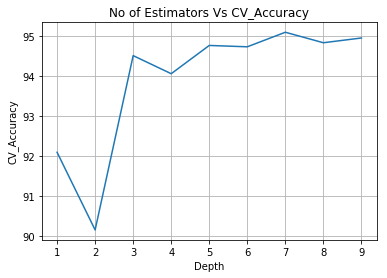

In [87]:
plt.plot(estimators,cv_scores)
plt.grid()
plt.title("No of Estimators Vs CV_Accuracy")
plt.xlabel("Depth")
plt.ylabel("CV_Accuracy")
plt.show()

In [88]:
optimal_n = estimators[cv_scores.index(max(cv_scores))]
print('\nThe optimal number of estimators is %d.' % optimal_n)


The optimal number of estimators is 7.


In [89]:
rf2= RandomForestClassifier(n_estimators=optimal_n)
rf2.fit(final_tf_idf_train,Y_Train)
pred1=rf2.predict(final_tf_idf_test)
acc1 = roc_auc_score(Y_Test, pred1,average='micro') * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_n, acc1))
f1_score_test= roc_auc_score(Y_Test, pred1)




The accuracy of the knn classifier for k = 7 is 94.663635%


Text(33,0.5,'Actual')

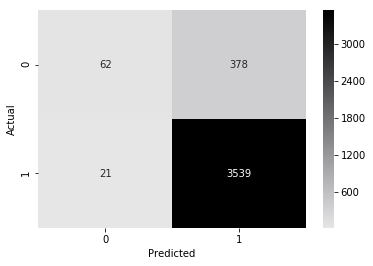

In [90]:
conf = (confusion_matrix(Y_Test,pred1))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [91]:
from sklearn.metrics import log_loss
logloss_1=log_loss(Y_Test,pred1)
logloss_1

3.4453185073494947

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

In [72]:
lst=list(range(1,10))
max_depth=[i for i in lst]
cv_scores1=[]
for k in max_depth:
    gbdt= GradientBoostingClassifier(max_depth=k,n_estimators=50)
    gbdt.fit(final_tf_idf_train,Y_Train)
    pred1 = gbdt.predict(final_tf_idf_cv)
    acc1 = roc_auc_score(Y_cv, pred1,average='micro')*100
    cv_scores1.append(acc1) 
  
 

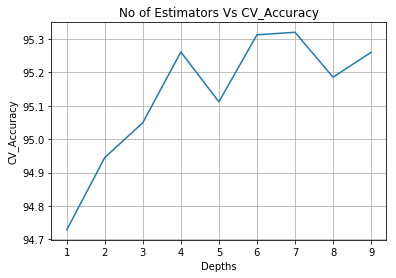

In [73]:
plt.plot(max_depth,cv_scores1)
plt.grid()
plt.title("max_depth Vs CV_Accuracy")
plt.xlabel("Depths")
plt.ylabel("CV_Accuracy")
plt.show()

In [75]:
optimal_n = max_depth[cv_scores1.index(max(cv_scores1))]
print('\nThe maximum depth is %d.' % optimal_n)


The maximum depth is 7.


In [76]:
gbm= RandomForestClassifier(n_estimators=optimal_n)
gbm.fit(final_tf_idf_train,Y_Train)
pred_gbm=gbm.predict(final_tf_idf_test)
acc_gbm= roc_auc_score(Y_Test, pred_gbm,average='micro') * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_n, acc_gbm))



The accuracy of the knn classifier for k = 7 is 94.497863%


Text(33,0.5,'Actual')

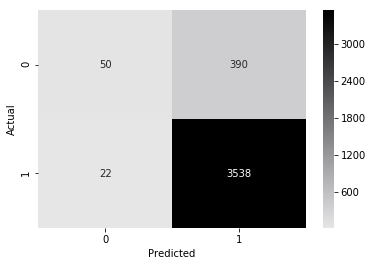

In [95]:
conf = (confusion_matrix(Y_Test,pred_gbm))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [77]:
import xgboost

In [78]:
#xgb=xgboost.XGBClassifier()

In [82]:
lst=list(range(1,10))
max_depth_xgc=[i for i in lst]
cv_scores_xgc=[]
for k in max_depth_xgc:
    xgc=xgboost.XGBClassifier(max_depth=k)
    xgc.fit(final_tf_idf_train,Y_Train)
    pred_xgc = xgc.predict(final_tf_idf_cv)
    acc_xgc = roc_auc_score(Y_cv, pred_xgc,average='micro')*100
    cv_scores_xgc.append(acc_xgc) 
  

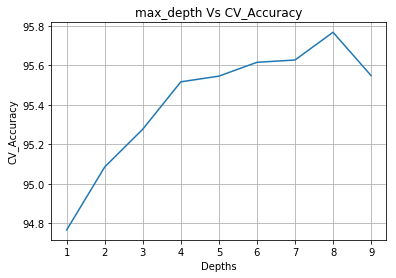

In [83]:
plt.plot(max_depth_xgc,cv_scores_xgc)
plt.grid()
plt.title("max_depth Vs CV_Accuracy")
plt.xlabel("Depths")
plt.ylabel("CV_Accuracy")
plt.show()

In [92]:
optimal_n = max_depth_xgc[cv_scores_xgc.index(max(cv_scores_xgc))]
print('\nThe maximum depth is %d.' % optimal_n)


The maximum depth is 8.


In [93]:
xgc1= xgboost.XGBClassifier(max_depth=optimal_n)
xgc1.fit(final_tf_idf_train,Y_Train)
pred_gbm1=xgc1.predict(final_tf_idf_test)
acc_gbm1= roc_auc_score(Y_Test, pred_gbm1,average='micro') * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_n, acc_gbm1))



The accuracy of the knn classifier for k = 8 is 95.434900%


Text(33,0.5,'Actual')

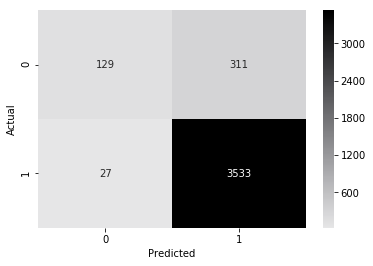

In [96]:
conf = (confusion_matrix(Y_Test,pred_gbm1))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# RF,GBDT,XGBoost Classification on AVG-W2V Data:

In [97]:
lst=list(range(1,10))
estimators=[i for i in lst]
cv_scores_avgrf=[]
for k in estimators:
    rf_avgrf= RandomForestClassifier(n_estimators=k)
    rf_avgrf.fit(sent_vectors,Y_Train)
    pred_avgrf = rf_avgrf.predict(sent_vectors_cv)
    acc_avgrf = roc_auc_score(Y_cv, pred_avgrf,average='micro')*100
    cv_scores_avgrf.append(acc_avgrf)   
 

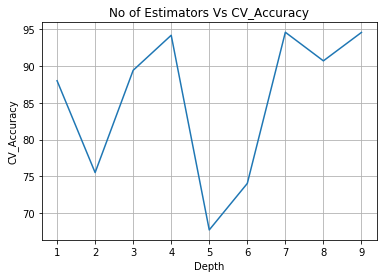

In [99]:
plt.plot(estimators,cv_scores_avgrf)
plt.grid()
plt.title("No of Estimators Vs CV_Accuracy")
plt.xlabel("Depth")
plt.ylabel("CV_Accuracy")
plt.show()

In [102]:
optimal_n = estimators[cv_scores_avgrf.index(max(cv_scores_avgrf))]
print('\nThe number of optimum estimators is %d.' % optimal_n)


The number of optimum estimators is 7.


In [105]:
rf_avgrf1= RandomForestClassifier(n_estimators=optimal_n)
rf_avgrf1.fit(sent_vectors,Y_Train)
pred_avgrf1=rf_avgrf1.predict(sent_vectors_test)
acc_avgrf1= roc_auc_score(Y_Test, pred_avgrf1,average='micro') * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_n, acc_avgrf1))



The accuracy of the knn classifier for k = 7 is 89.741078%


Text(33,0.5,'Actual')

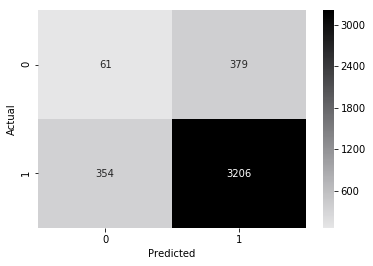

In [106]:
conf = (confusion_matrix(Y_Test,pred_avgrf1))
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0, as_cmap=True)
sns.heatmap(conf,cmap = cmap,xticklabels=['0','1'],yticklabels=['0','1'],annot=True, fmt="d",)
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Conclusion:

As it is seen that the Xgboost classifier performed the best in TF-IDF data among all the classifiers in terms of ROC_AUC_SCORE  95.434% and True Predictions.